In [1]:
%matplotlib inline
import sys
sys.path.append('/home/ubuntu/tools/python-genomics')
import Scanpyplus
from importlib import reload
import pandas as pd
import scanpy.api as sc
import anndata
import os
import numpy as np
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80,dpi_save=300,color_map='PuRd')
sc.logging.print_version_and_date()

import matplotlib
import matplotlib.pyplot as plt
plt.show()
matplotlib.rcParams.update({'figure.figsize': (8,8)})
import pandasPlus

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-n_0k3tzp because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Running Scanpy 1.5.0, on 2021-03-25 12:22.


If you use DeepTree please cite this: [He et al. 2020 Nature](https://www.nature.com/articles/s41586-020-2536-x)

## Follow Scanpy's tutorial as usual

In [10]:
import os
os.system('wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O pbmc3k_filtered_gene_bc_matrices.tar.gz')
os.system('tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz')

0

... writing an h5ad cache file to speedup reading next time
filtered out 19024 genes that are detected in less than 3 cells
normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:16)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adat

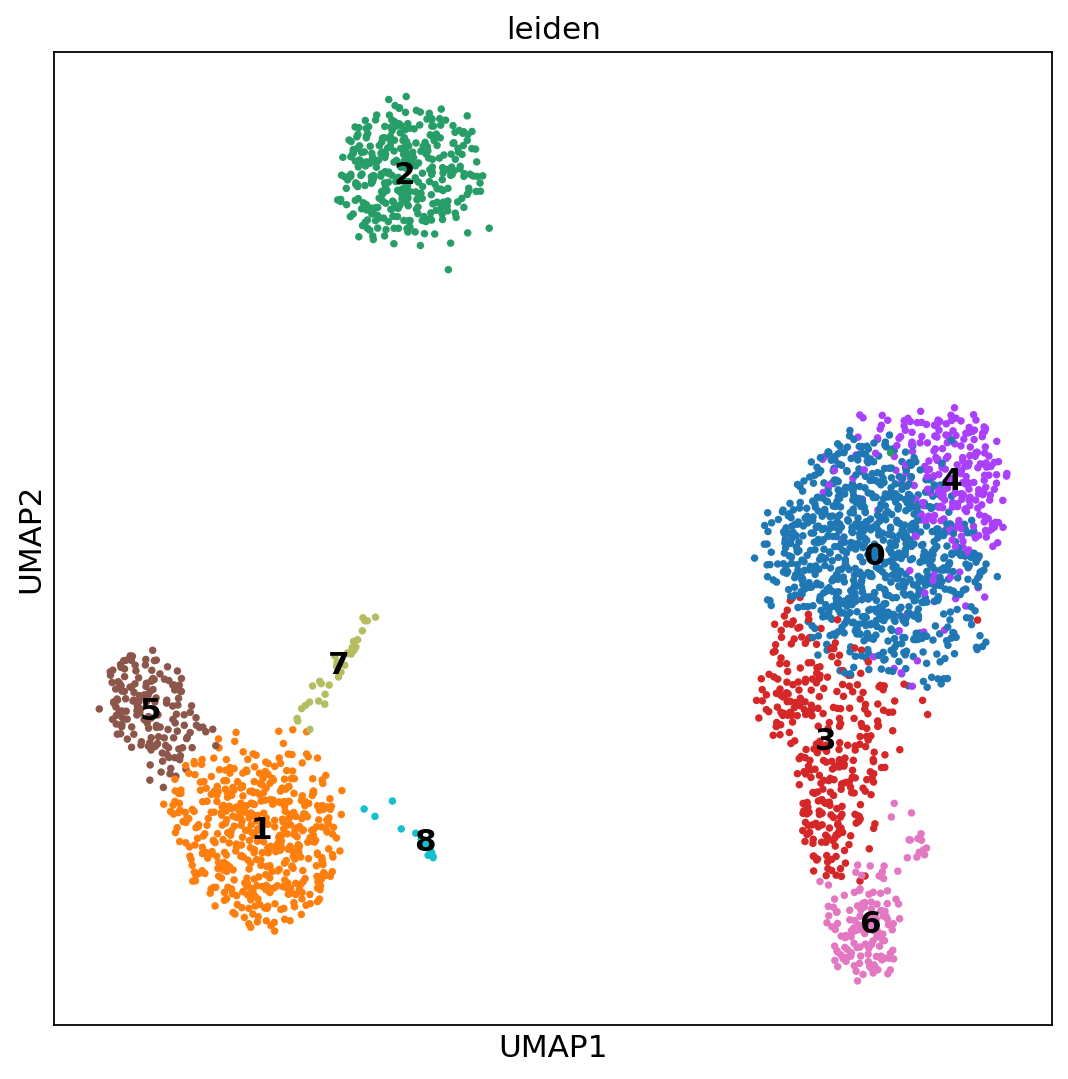

In [11]:
#Scanpy tutorial is here https://icb-scanpy-tutorials.readthedocs-hosted.com/en/latest/pbmc3k.html
adata = sc.read_10x_mtx(
    './filtered_gene_bc_matrices/hg19/',# the directory with the `.mtx` file
    var_names='gene_symbols',  # use gene symbols for the variable names
    cache=True)     
adata.var_names_make_unique()

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3) 

mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

adata = adata[adata.obs.n_genes < 2500, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.3)

bdata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(bdata, ['n_counts', 'percent_mito'])
sc.pp.scale(bdata, max_value=10)
sc.tl.pca(bdata, svd_solver='arpack')
sc.pp.neighbors(bdata, n_neighbors=10, n_pcs=40)
sc.tl.umap(bdata)
sc.tl.leiden(bdata)
sc.pl.umap(bdata, color='leiden', legend_loc='on data')

In [12]:
bdata

AnnData object with n_obs × n_vars = 2638 × 2250
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Perform DeepTree selection

Trying to set attribute `.var` of view, copying.


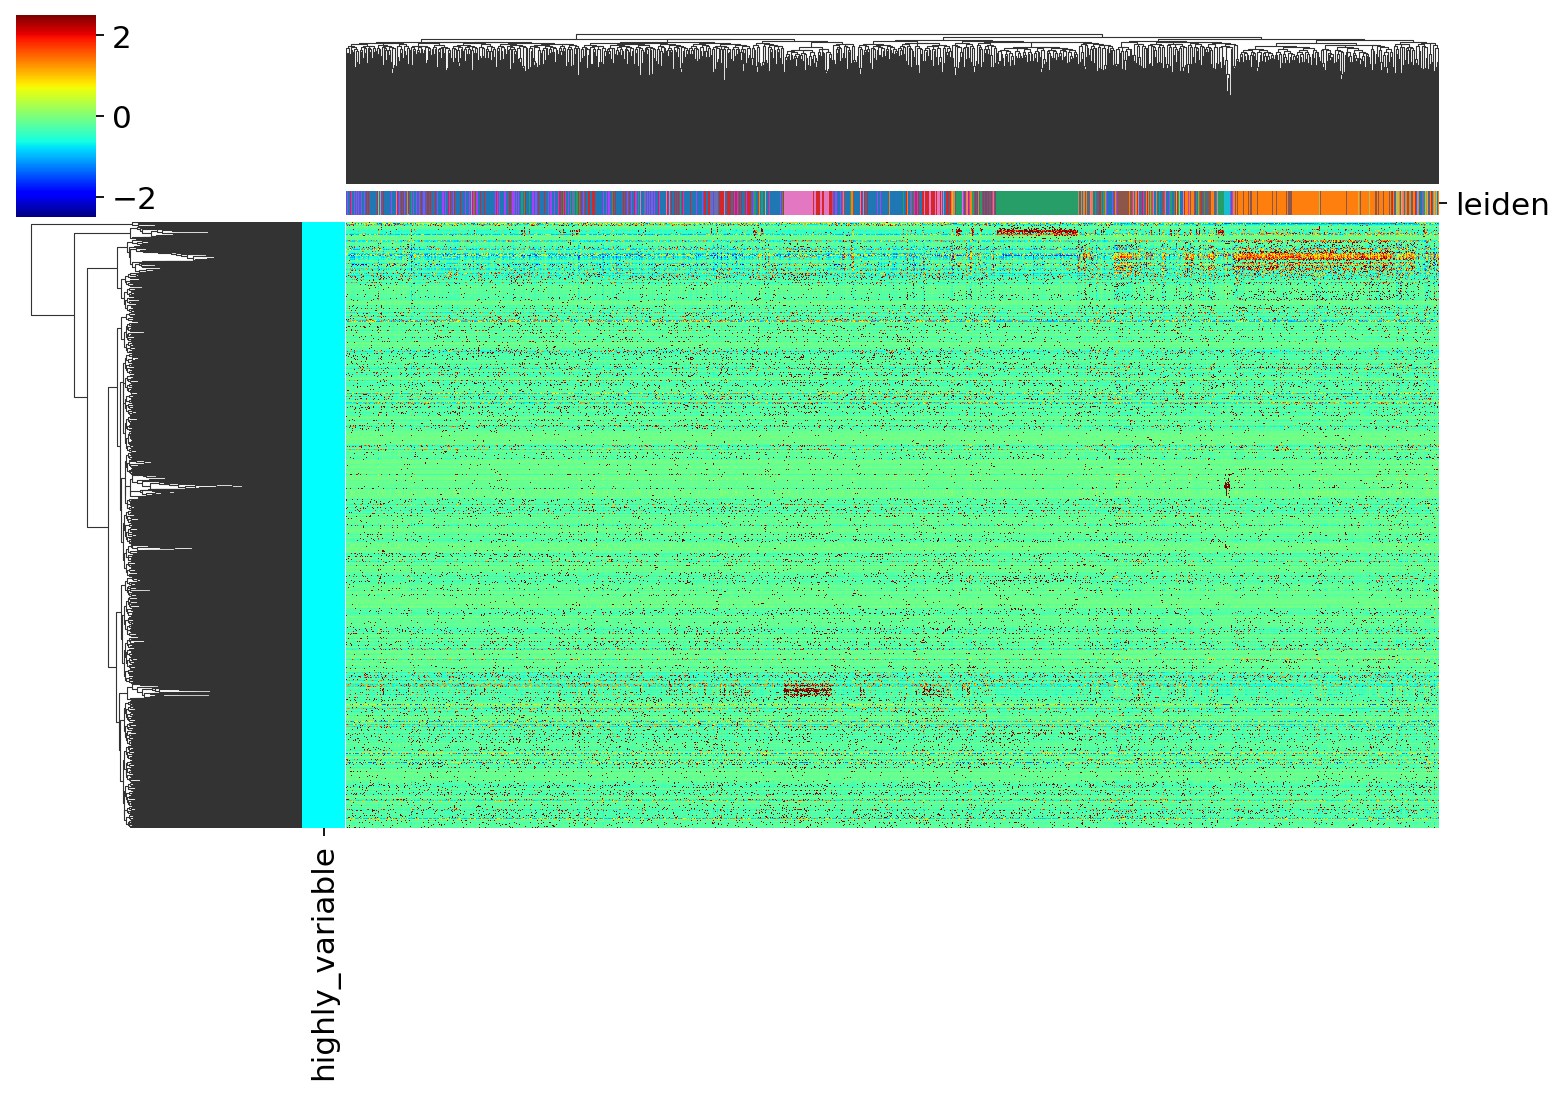

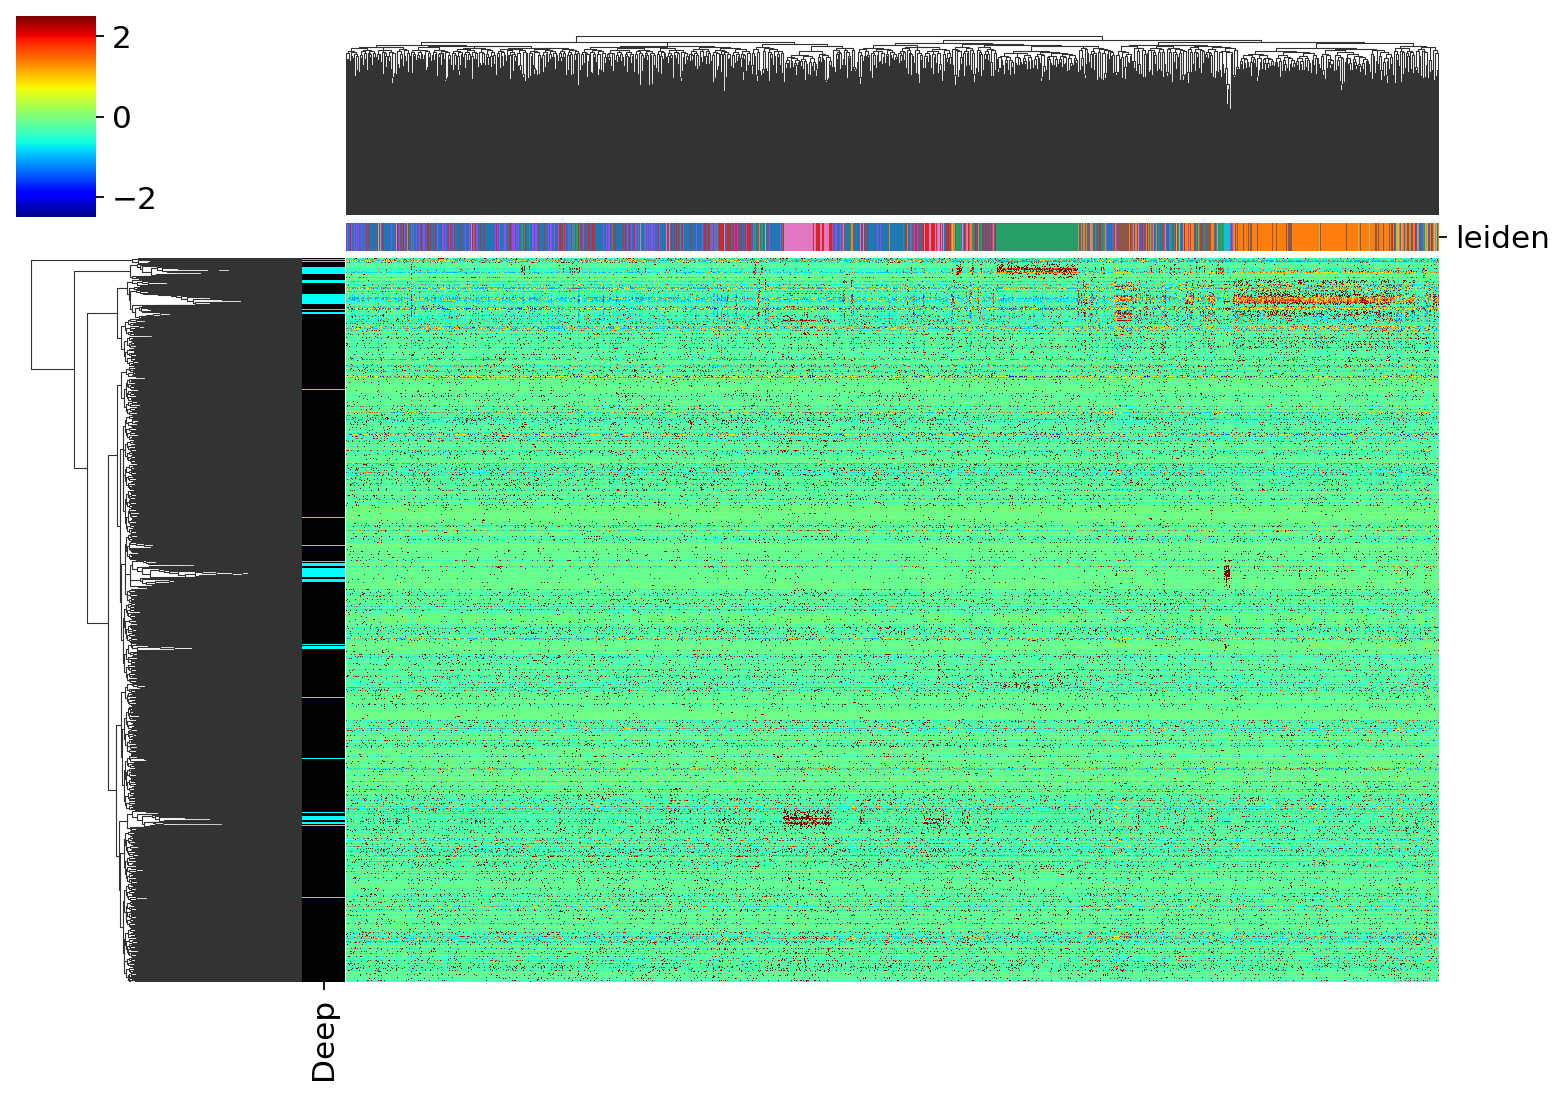

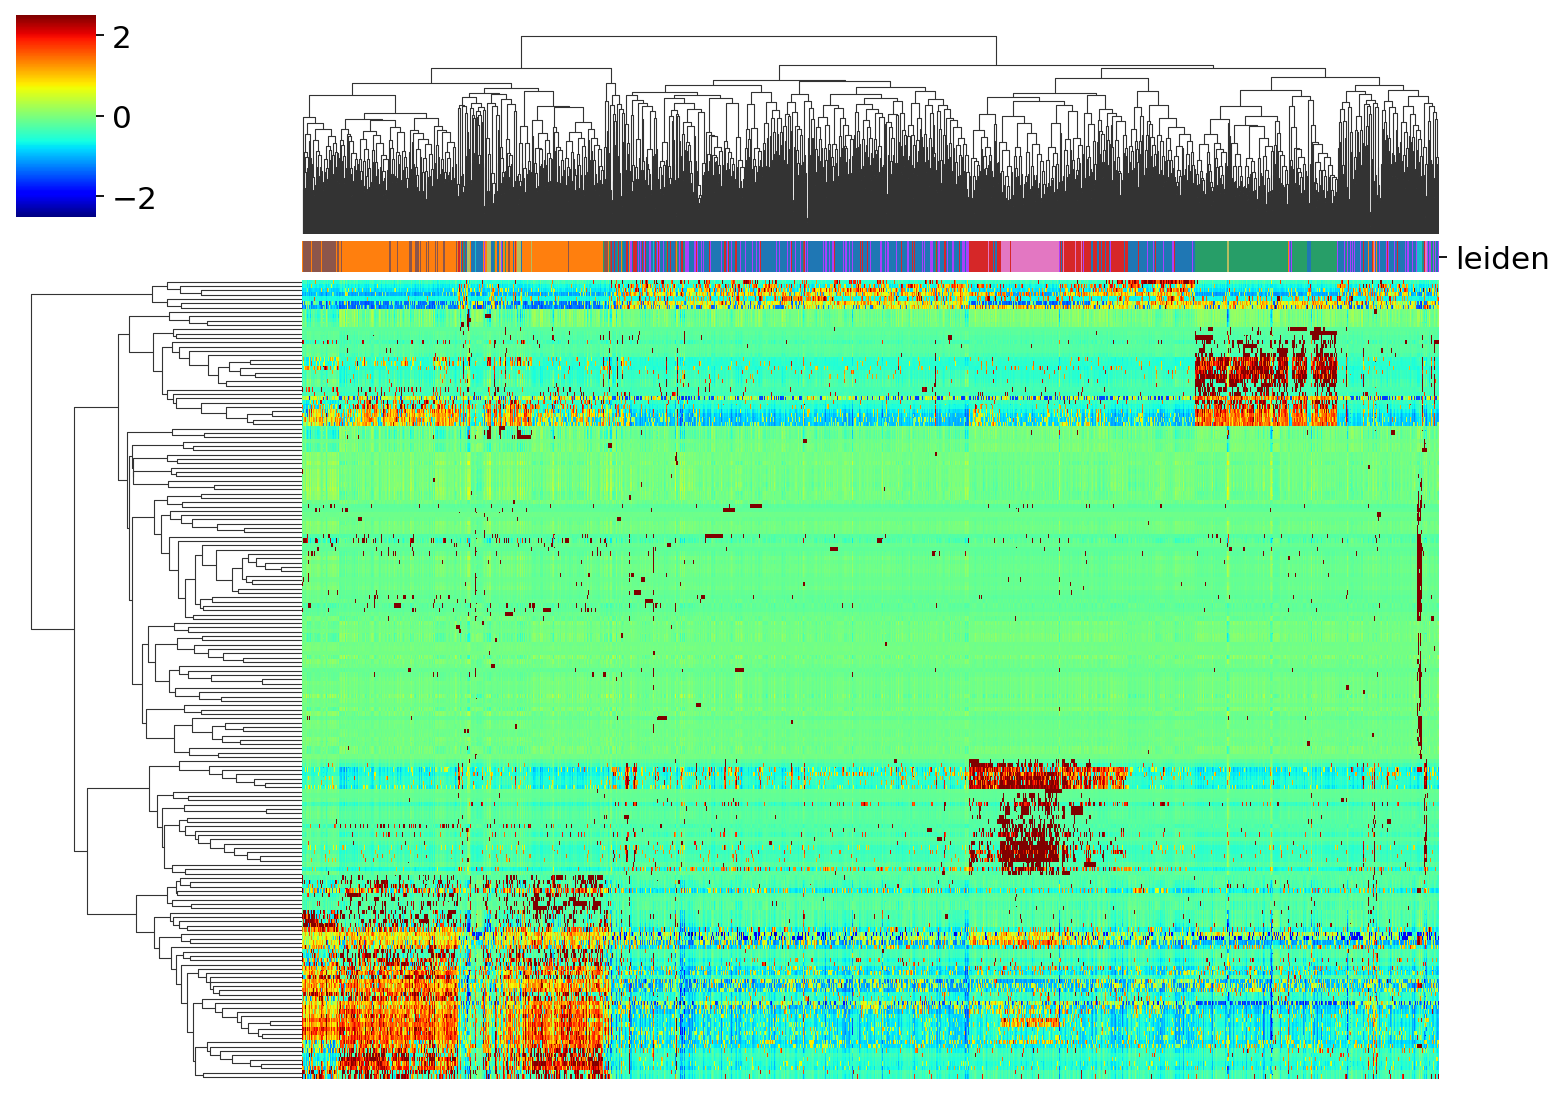

In [13]:
[bdata, output1, output2, output3] = Scanpyplus.DeepTree(bdata,
                           MouseC1ColorDict2={False:'#000000',True:'#00FFFF'}, #This specifies rowlabel colors
                           cell_type='leiden', #This specieis the .obs variable you are interested in
                           row_cluster=True,col_cluster=True #This lets the function clusters the rows and columns
                           )

This generates three clustermaps stored in output1, output2 and output3

The first clustermap is an overview of the top 4000 highly-variable genes. As you can see only a small subset of them show coherent patterns. Color bars on the top shows cell cluster IDs from the previous straight forward clustering.

The second clustermap highlights the DeepTree-selected genes using cyan on the left. The selection gets rid of most sporadic noises.

The third clustermap shows how cell clustering will improve if we only use the DeepTree-selected genes

In [14]:
bdata.var['Deep']

ISG15       False
AGRN        False
TNFRSF18    False
TNFRSF4     False
CPSF3L      False
            ...  
SUMO3       False
SLC19A1     False
S100B       False
PRMT2       False
MT-CYB      False
Name: Deep, Length: 2250, dtype: bool

## Use DeepTree-selected genes to replace HVG for downstream analysis

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


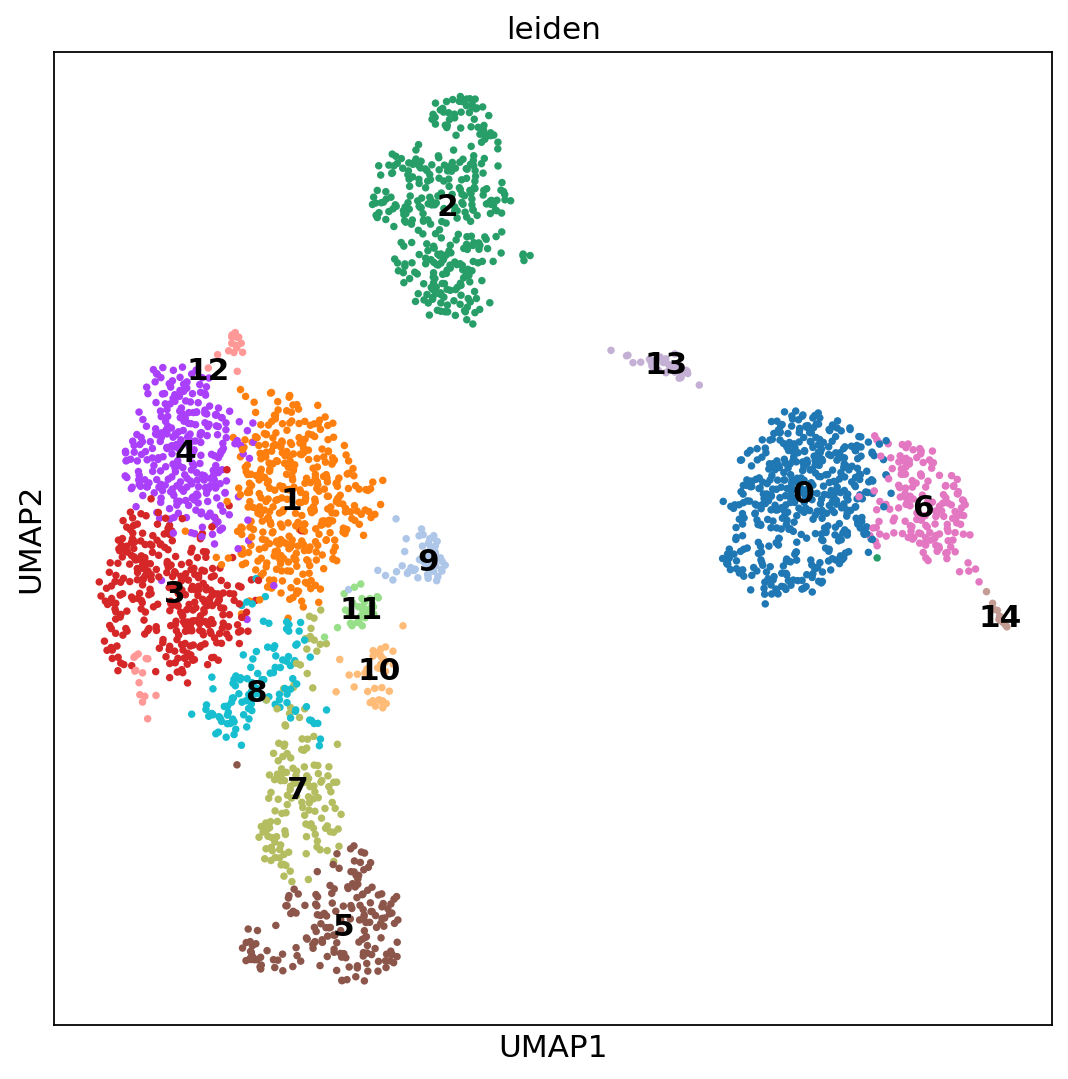

In [15]:
#Now use these genes to replace highly-variable genes for data analysis.

bdata=bdata[:,bdata.var['Deep']]
sc.tl.pca(bdata, svd_solver='arpack')
sc.pp.neighbors(bdata, n_neighbors=10, n_pcs=40)
sc.tl.umap(bdata)
sc.tl.leiden(bdata)
sc.pl.umap(bdata, color='leiden', legend_loc='on data')

As we can see more clusters emerge. But are they interesting? Let's check

In [16]:
#transfer the coordinates and clustering info back to the full dataset
adata.obsm['X_umap']=bdata.obsm['X_umap']
adata.obs['leiden']=bdata.obs['leiden']

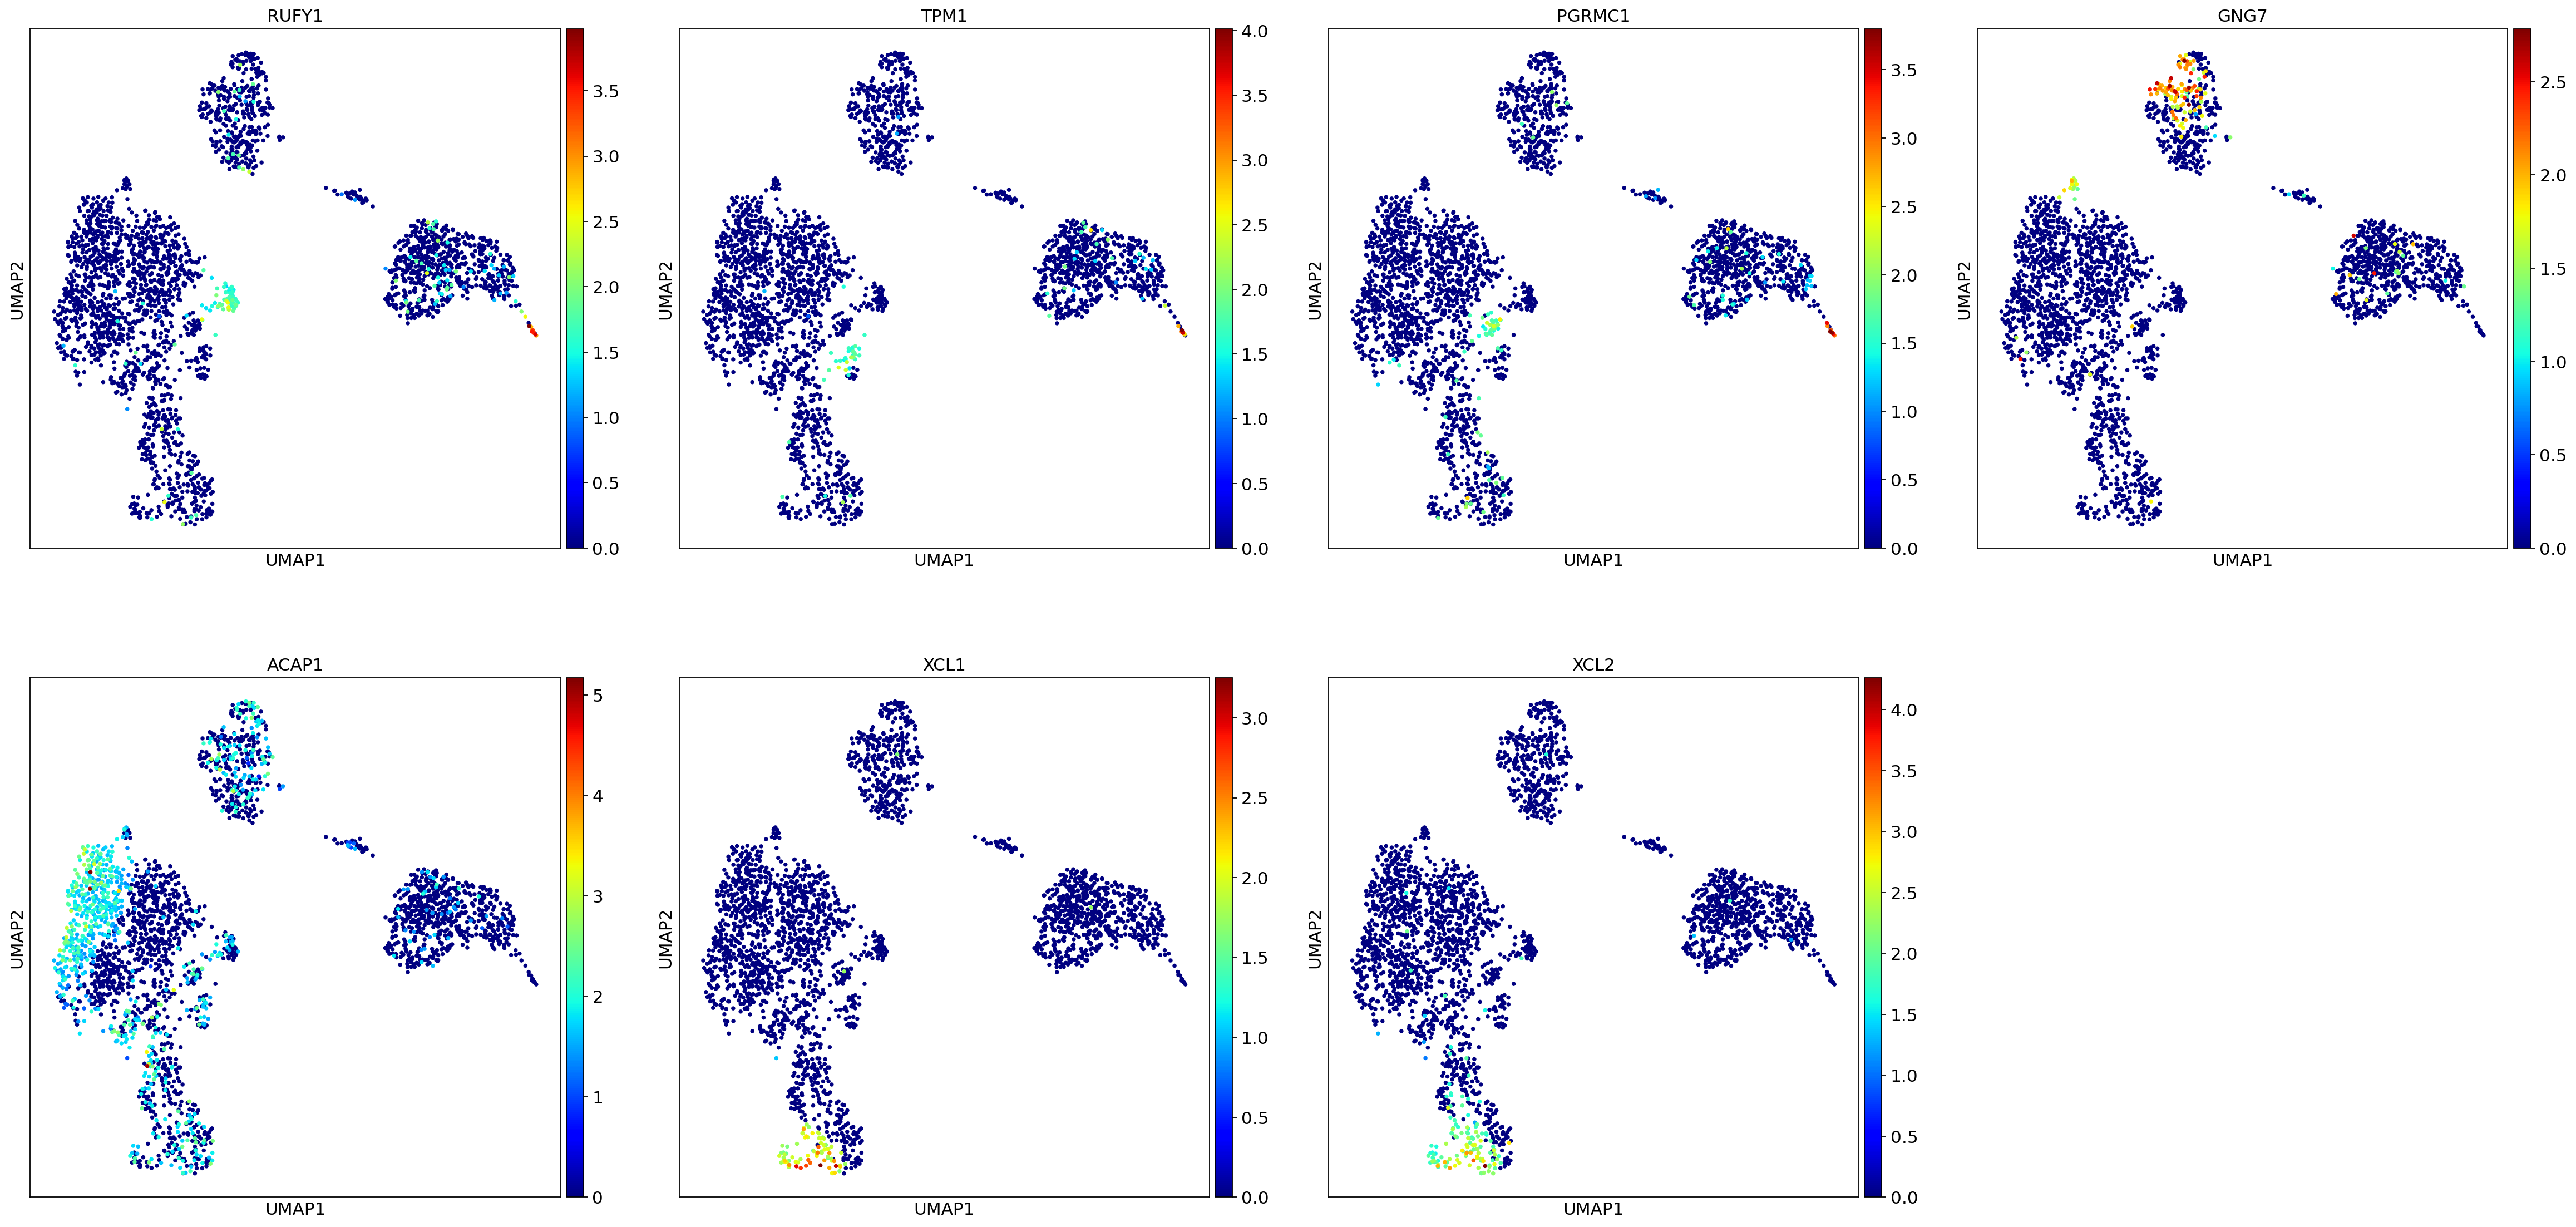

In [25]:
sc.pl.umap(adata,color=['RUFY1','TPM1','PGRMC1','GNG7','ACAP1',
                       'XCL1','XCL2'],color_map='jet')

Overall, DeepTree de-noise method reveals more subtle structures of the data using the same parameters chosen by Scanpy's tutorial. It may potentially reduce the number of rounds of subclustering needed for deep annotation.

It will be interesting to follow the subtle differences between these subclusters to see whether they do have biological meanings